# <b>Lab 2</b>: Classifications: Logistics, SVM, KNN, and RandomForest
# <center><font color='blue'>Student Exam Scores Extended Dataset</font></center> 
***
### <center><b> Team Members: </b> Joey Hernandez, Daniel Chang, and Vo Nguyen</center>

### <b> Contributions: </b>
- Logistic Model: **Vo Nguyen**
- KNN: Joey Hernandez
- RandomForest: Danny Chang

### <b>Table of Contents</b>
<a class="anchor" id="toc"></a>
* **[Data Preprocessing](#data)**
    * [Import Packages](#import)
    * [Loading the Data](#load)
    * [Dataset Cleaning: One-Hot Encoding](#hot)
    * [Response Variable into Categorical](#response)
* **[Logistic Regression](#logistic)**
* **[KNN](#knn)**
* **[RandomForest](#rf)**
* **[Conclusion](#conclusion)**

# Introduction

The dataset (fictional) comprises scores from three tests of students at a public school, as well as personal and socio-economic factors that may have interaction effects. The purpose of collecting this data is to identify potential relationships between personal and socio-economic factors and test scores. By understanding which factors have the most significant impact on test scores, educators, parents, and students can focus their attention on variables that could potentially help students earn higher scores. This information can be used to inform educational policies and practices, as well as to develop targeted interventions to support students who may be struggling academically. Ultimately, the goal of collecting this data is to improve educational outcomes and promote academic success for all students.

Student education and testing scores are critical to their future success. Education provides the foundation upon which students will build their future, and improving the efficiency of learning and testing experiences can have a positive impact on many students' futures. By analyzing the dataset, we can identify factors that influence student performance and develop strategies to improve academic outcomes.

Additionally, we will be performing three different classification models: Logistic Regression, KNN (K-Nearest Neighbors), and Random Forest. Each model brings its own strengths and characteristics to the analysis. Logistic Regression offers interpretability and the ability to estimate coefficients, enabling us to understand the impact of different factors on test results. KNN, on the other hand, is a non-parametric algorithm that can handle complex relationships and doesn't require training time. Lastly, Random Forest leverages an ensemble of decision trees to improve robustness and accuracy, providing feature importance rankings. By comparing the results of these three models, we can gain a comprehensive understanding of the data and identify the most effective approach for classifying pass or fail test results. This analysis will help inform educators, policymakers, and stakeholders in making data-driven decisions to support student success and enhance the educational system.

### Import Packages [↑](#toc)
<a class="anchor" id="import"></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
sns.set_style('whitegrid')

from sklearn.metrics import mean_squared_error

from sklearn.metrics import accuracy_score, confusion_matrix

### Loading the Data [↑](#toc)
<a class="anchor" id="load"></a>

In [104]:
df = pd.read_csv('cleandf.csv')
display(df)

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore,MathResult,ReadingResult,WritingResult
0,female,group C,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74,Pass,Pass,Pass
1,female,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,69,90,88,Fail,Pass,Pass
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91,Pass,Pass,Pass
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,school_bus,5 - 10,45,56,42,Fail,Fail,Fail
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75,Pass,Pass,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30636,female,group D,high school,standard,none,single,sometimes,no,2.0,school_bus,5 - 10,59,61,65,Fail,Fail,Fail
30637,male,group E,high school,standard,none,single,regularly,no,1.0,private,5 - 10,58,53,51,Fail,Fail,Fail
30638,female,group C,high school,free/reduced,completed,married,sometimes,no,1.0,private,5 - 10,61,70,67,Fail,Pass,Fail
30639,female,group D,associate's degree,standard,completed,married,regularly,no,3.0,school_bus,5 - 10,82,90,93,Pass,Pass,Pass


### Dataset Cleaning: One-Hot Encode [↑](#toc)
<a class="anchor" id="hot"></a>

One Hot-Encode

In [105]:
df_dummy = pd.get_dummies(df, columns=['Gender', 'LunchType', 'TestPrep', 'IsFirstChild','TransportMeans'],
                          drop_first=True)
df_dummy["WklyStudyHours"] = [1 if x == '> 10' else 0 for x in df_dummy["WklyStudyHours"]]

df_dummy["PracticeSport"] = [0 if x == 'never' else 1 for x in df_dummy["PracticeSport"]]

math_df = df_dummy.drop(["ReadingResult", "WritingResult", "MathScore"], axis = 1)

math_df['HasSiblings'] = math_df['NrSiblings'].apply(lambda x: 1 if x > 0 else 0)

math_df.drop('NrSiblings', axis=1, inplace=True)

## Response Variable Math Test Score into Math Results Binary (Pass or Fail) [↑](#toc)
<a class="anchor" id="response"></a>

In [106]:
math_df['MathResultNum'] = np.where(math_df['MathResult'] == "Pass", 1, 0)

# Modeling & Evaulation

When evaluating our models will use the following metrics:

- **Confusion Matrix:** Provides tabular representation of the predicted versus acutal class labels. The confusion matrix 
allows for a detailed analysis of the model's performance and evaluation of different metrics (some of which we will include below)<br><br>

- **Accuracy:** Will help us to assess the overall Correctness of the model predictions. While it is not particualrly useful as a standalone metric it will provide a piece to a comprehensive look at our model performance.<br><br>

- **Precision:** It represents the proportion of correctly predicted positive instances (true positives) out of the total instances predicted as positive. Precision is useful when the cost of false positives is high, and we want to minimize false positives. It's important that we are able to identify students whom are classified as a "True Pass" so that we can ensure students are receiving the needed attention and help.<br><br>

- **Recall** Provides a measure for how many actual positive instances are correctly predicted as positive. "of all the positive instances how many are correctly predicted" This is important for us to understand so that we are not classiying students as "Pass" when they are actually likely to fail, which may prevent them from receiving the help they need.<br><br>

- **F1 Score:** By considering precision and recall simultaneously, the F1 score provides a balanced and comprehensive assessment of the model's performance for grade pass/fail classification. It helps in evaluating the model's ability to correctly identify both pass and fail cases, addressing imbalanced performance, and incorporating the potential costs associated with misclassifications in a meaningful way.<br><br>

- **AUC:** Represents the overall performance of the classifier across various classification thresholds. AUC-ROC is particularly useful when evaluating binary classification problems with imbalanced classes or when the emphasis is on ranking the instances.<br><br>

# Train Test Split Method

### Entire Data Split & Stratified 10 Fold Cross Validation

Upon revisiting the count plot for "Pass/Fail" instances mentioned earlier, it has become evident that our data exhibits a slight imbalance. To address this concern, we will adopt a comprehensive approach that includes a Train/Test split on the entire dataset prior to conducting the Stratified 10 Fold Cross Validation for each model.

The incorporation of a Train/Test split ensures that our dataset is divided into distinct training and testing subsets before proceeding with the Stratified 10 Fold Cross Validation. This step allows us to assess the performance of our models on unseen data during the testing phase.

In comparison to the traditional 'train_test_split' method, the Stratified Cross Validation method provides us with enhanced precision when dealing with an unbalanced response variable. By employing stratification, we guarantee that each fold in the cross-validation process maintains the same distribution of "Pass/Fail" classes as the original dataset, thereby minimizing potential biases and improving the reliability of our model evaluation.

# Logistic Regression - Vo Nguyen  [↑](#toc)
<a class="anchor" id="logistic"></a>

### Import Packages for Logistics Regression

In [6]:
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
sns.set_style('whitegrid')
from pandas import Series,DataFrame
import numpy as np
import statsmodels.formula.api as smf

### Plot of our Target Variable
The plots have a slight imbalance dataset. We will proveed in comparing a regular 70-30 split to a Stratified 10-Fold CV to compare. Additionally, for the sake of our analysis, since we have a close imbalance dataset. We will not go with a oversamplgin resample function, but rather focus on adjusting the threshold according to our ROC.

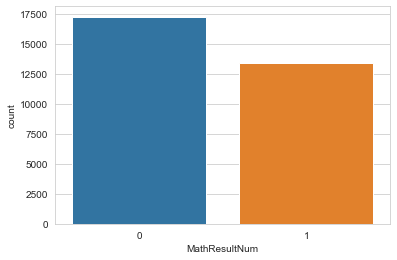

In [7]:
sns.countplot(data = math_df, x = 'MathResultNum')
plt.show()

Since we have an imbalance dataset. We can use the Receiver Operating Characteristic(ROC) curve to the examin the area under curve (AUC). The threshold that maximmizes our trade-off between true positive(sensitivity) and false posited rate can be a considered a good theshold for our classification. 

### Logistic Regression Model Summary

In [8]:
# building the model and fitting the data
Target = math_df["MathResultNum"]
feature_columns = math_df.drop(["EthnicGroup", "ParentEduc", "ParentMaritalStatus",
                                "MathResult", "HasSiblings","MathResultNum"], axis = 1)
formula = "MathResultNum ~ " + " + ".join(feature_columns)

log_reg = smf.logit(formula, data=math_df).fit()

print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.264558
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          MathResultNum   No. Observations:                30641
Model:                          Logit   Df Residuals:                    30631
Method:                           MLE   Df Model:                            9
Date:                Fri, 30 Jun 2023   Pseudo R-squ.:                  0.6138
Time:                        23:21:21   Log-Likelihood:                -8106.3
converged:                       True   LL-Null:                       -20993.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -24.1572      0.302    -79.999      0.000     -24.

## External Cross Validation using SKLEARN

### Training a Logistic Regression Model 70-30 split

# Split for Entire Data Set

In [107]:
Train_entire, Test_entire= train_test_split(math_df, train_size = .7, test_size= .3, random_state=5)

In [10]:
# dataset 'df' is now Train/ Test

Train, Test = train_test_split(Train_entire, train_size = .7, test_size = .3, random_state=5)

X_train = Train.drop(["EthnicGroup", "ParentEduc", "ParentMaritalStatus", "MathResult", "HasSiblings","MathResultNum"], axis = 1)
y_train = Train.MathResultNum

X_test = Test.drop(["EthnicGroup", "ParentEduc", "ParentMaritalStatus", "MathResult", "HasSiblings","MathResultNum"], axis = 1)
y_test = Test.MathResultNum

#Create Logistic Classifier and Fit
clf = LogisticRegression(random_state=0).fit(X_train,y_train)

#Create Prediction Set
preds1 = clf.predict(X_test)

#Accuracy Method 1
print("Accuracy:",metrics.accuracy_score(y_test, preds1))

#RMSE
MSE = mean_squared_error(y_test,preds1)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)

Accuracy: 0.875058275058275
RMSE: 0.35347096760798463


### Stratified 10-Fold Cross Validation for Training the Logistic Regression Model

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

X = math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = math_df['MathResultNum']

log_clf = LogisticRegression(random_state=0)

cross_val_scores = cross_val_score(log_clf, X, y, cv=10)

avg_accuracy = cross_val_scores.mean()

print("Average CV Score Accuracy:", avg_accuracy)

preds = cross_val_predict(log_clf, X, y, cv=10)

MSE = mean_squared_error(y,preds)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)


Average CV Score Accuracy: 0.8786920572112497
RMSE: 0.3482930537691049


**A Train 70-30 split and a Stratified 10-Fold Cross Validation are similar in terms of accuracy score and RMSE; however, we want to treat our imbalance dataset seriously, but we can to do what we did on the our previous mini lab**

### Plot the AUC

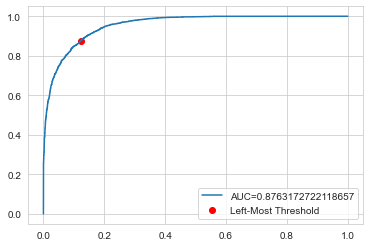

Optimal Threshold
0.41227259269063177
Recall
[0.00000000e+00 3.58808755e-04 7.17617510e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]



In [12]:
#Import Packages
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = clf.predict_proba(X_test)[:,1]
fpr,tpr, thresholds = roc_curve(y_test,y_pred_proba)

auc = metrics.roc_auc_score(y, preds)

#Find the Left Most Index
leftmost_index = np.nanargmin(np.abs(fpr - (1 - tpr)))
leftmost_fpr = fpr[leftmost_index]
leftmost_tpr = tpr[leftmost_index]

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.scatter(leftmost_fpr, leftmost_tpr, color='red', label="Left-Most Threshold")
plt.legend(loc=4)
plt.show()

#Optimal Threshhold
print("Optimal Threshold")
print(thresholds[np.argmax(tpr - fpr)])
print("Recall")
print(tpr)
print()


https://towardsdatascience.com/calculating-and-setting-thresholds-to-optimise-logistic-regression-performance-c77e6d112d7e

## Confusion Matrix

A confusion matrix is an essential tool for evaluating the performance of a model that predicts the "Pass" or "Fail" outcome of math test scores. It provides a clear and concise summary of the model's predictions and their alignment with the actual outcomes. By examining the confusion matrix, users can gain valuable insights into the model's effectiveness in identifying "Pass" and "Fail" instances.

Here's why and how a confusion matrix would be interesting to someone using such a model:

- Performance Evaluation: The confusion matrix allows users to assess the model's accuracy and understand the distribution of predictions across different classes. It provides a comprehensive overview of the true positives (correctly predicted "Pass" instances), true negatives (correctly predicted "Fail" instances), false positives (incorrectly predicted as "Pass" when the actual outcome is "Fail"), and false negatives (incorrectly predicted as "Fail" when the actual outcome is "Pass"). These metrics help users evaluate the model's overall performance and identify any potential biases or weaknesses.
<br><br>
- Imbalance Assessment: In scenarios where there is an imbalance in the dataset, such as a higher frequency of "Pass" or "Fail" instances, a confusion matrix becomes even more crucial. It allows users to observe the distribution of predictions across classes and assess if the model is biased towards one class. This information helps in identifying potential issues and determining if further measures, such as class weighting or data balancing techniques, need to be employed to improve the model's performance.
<br><br>
- Precision and Recall Analysis: The confusion matrix enables users to calculate additional metrics such as precision and recall. Precision represents the proportion of correctly predicted "Pass" instances out of all instances predicted as "Pass," while recall indicates the proportion of correctly predicted "Pass" instances out of all actual "Pass" instances. These metrics provide a deeper understanding of the model's performance and can be useful for making informed decisions, especially when the cost of false positives or false negatives varies.
<br><br>
- Model Fine-tuning: By analyzing the confusion matrix, users can identify specific patterns or trends in the model's misclassifications. They can then make targeted adjustments, such as modifying the model's parameters, adjusting the decision threshold, or exploring different feature engineering techniques, to improve the model's accuracy and address specific challenges.

[[3225  423]
 [ 381 2406]]


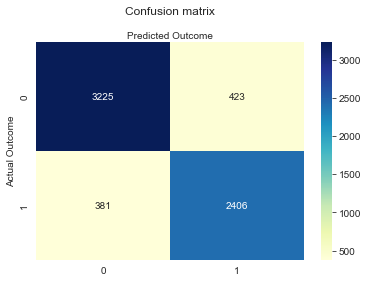

In [13]:
cnf_matrix = metrics.confusion_matrix(y_test, preds1)
print(cnf_matrix)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)


# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')
plt.show()

In [14]:
Performance = DataFrame({"Actual":y_test,"Predicted":preds1})
Performance["Subtract"] = Performance["Actual"]-Performance["Predicted"]
Accuracy = (Performance["Actual"].count() - sum(abs(Performance["Subtract"])))/Performance["Actual"].count()
print("Accuracy Method 2")
print(Accuracy)

from sklearn.metrics import classification_report
print(classification_report(y_test, preds1))
print("No Informaiton Rate")
print(np.mean(1-math_df["MathResultNum"]))

Accuracy Method 2
0.875058275058275
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3648
           1       0.85      0.86      0.86      2787

    accuracy                           0.88      6435
   macro avg       0.87      0.87      0.87      6435
weighted avg       0.88      0.88      0.88      6435

No Informaiton Rate
0.5632975425084038


### Reclassify on a Threshold of 0.39 and Examine CM Metrics using Stratified 10-Fold CV

In [15]:
log_clf = LogisticRegression(random_state=1)

threshold = 0.3886995893248815

log_clf.fit(X_train, y_train)

log_clf_probs = log_clf.predict_proba(X_test)[:,1]

preds = np.where(log_clf_probs >= threshold, 1, 0)

MSE = mean_squared_error(y_test,preds)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)


RMSE: 0.35609904072677145


### Confusion Matrix

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      3648
           1       0.82      0.91      0.86      2787

    accuracy                           0.87      6435
   macro avg       0.87      0.88      0.87      6435
weighted avg       0.88      0.87      0.87      6435

No Informaiton Rate
0.5632975425084038


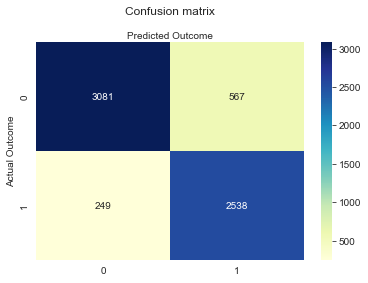

In [16]:
cnf_matrix = metrics.confusion_matrix(y_test, preds)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)


# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')

from sklearn.metrics import classification_report
print(classification_report(y_test, preds))
print("No Informaiton Rate")
print(np.mean(1-math_df["MathResultNum"]))

### Internal 5-Fold Cross Validation for Threshold of 0.39

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


# prepare the cross-validation procedure
cv = KFold(n_splits=5, shuffle = True, random_state=1)

X = math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = math_df['MathResultNum']

# create model
model = LogisticRegression(random_state=1).fit(X,y)
threshold = 0.3886995893248815



log_clf_probs = model.predict_proba(X)[:,1]
preds = np.where(log_clf_probs >= threshold, 1, 0)

probs = cross_val_predict(model, X, y, cv=5, method='predict_proba')
predicted_class = (probs[:, 1] > threshold).astype(int)

cv_score = accuracy_score(y, predicted_class)

print("Cross-validation score (accuracy):", cv_score)


# evaluate model
scoresAcc = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scoresRec = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
scoresPrec = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
scoresF1 = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)


# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scoresAcc), np.std(scoresAcc)))
print('Recall: %.3f (%.3f)' % (np.mean(scoresRec), np.std(scoresRec)))
print('Precision: %.3f (%.3f)' % (np.mean(scoresPrec), np.std(scoresPrec)))
print('F1: %.3f (%.3f)' % (np.mean(scoresF1), np.std(scoresF1)))

Cross-validation score (accuracy): 0.8764074279560067
Accuracy: 0.878 (0.003)
Recall: 0.857 (0.007)
Precision: 0.863 (0.006)
F1: 0.860 (0.003)


## Logistic Model Evaluation 

| Metric    | Threshold = 0.50 | Threshold = 0.39     |
|---------|-----|----------|
| **Accuracy**    | 0.88  | 0.88 |
|  **Precision**   | 0.88  | 0.89   |
| **Recall** | 0.88 | 0.88    |
| **F1 Score**  | 0.88  | 0.88    |
| **AUC-ROC**  | 0.87  | 0.88    |
| **RMSE**  | 0.342  | 0.342    |


### Advantages to Using Logistics Regression
- **Interpretability:** Logistics provides interpretability results as it can estimate the coefficients, thus we can use a simple odds ratio interpretation associated to each input feature. Additionally, the coefficient has a good interpretation of increasing or decreasing the response with a good cofidence interval. 
<br><br>
- **Probabilities:** Logistic Regression provides probability estimates for response. This is good because we can make business decision based on this confidnece level or want to analyze uncertainties of predictions. <br><br>
- **Robustness:** As you can see from our dataset, we have the ability to handle imbalance datasets more effectively by using appropriate techniques of thresholding.
<br><br>


# Conclusion - Logistic Regression

In this analysis, a logistic regression model is chosen as the starting point due to its several advantages. Logistic regression offers interpretability by estimating coefficients, allowing for a clear understanding of each input feature's impact on the likelihood of passing or failing the math test. It also provides probability estimates, which are useful for making business decisions and assessing prediction uncertainties. The ability to quantify the probability of passing or failing can aid in identifying students who may require additional support. An important visual included in our results is  the Receiver Operating Characteristic (ROC) curve. This allows us to visually see the trade-off between true positives and false positives when selecting various thresholds.
Lastly, the results we achieved with our logistic regession model are as follow:

Accuracy: .88<br>
Precision: .88<br>
Recall: .88<br>
F1 Score: .88<br>
AUC-ROC: .87<br>
RMSE: .34

<hr>

# KNN - Joey  [↑](#toc)
<a class="anchor" id="logistic"></a>


## Import Packages for KNN, TTS, ETC

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

## View Occurances of MathResultNum

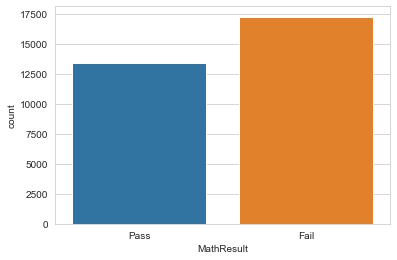

In [19]:
sns.countplot(data = math_df, x = 'MathResult')
plt.show()

### There seems to be evidence of a slight imbalance in our repsonse variable. Because of this we will proceed with Stratified Cross Validation for splitting up our data.

In [20]:
counts = math_df['MathResult'].value_counts()
ratio = counts[0] / counts[1]
print('Class Imbalance Ratio:', ratio)

Class Imbalance Ratio: 1.2898886480831029


## Normalize The continous Variables for use in KNN

Becuase our model will contain both binary variable and continuous variables we will normlize the two continuous variables to ensure that KNN is making accurate predictions. 

KNN is a distance based algorithm, meaning it will rely on measuring distance between data points to make predictions. When features have different scales, attributes with larger values may dominate the distance calcuations.

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_math_df = Train_entire
scale_math_df[['ReadingScore','WritingScore']] = scaler.fit_transform(Train_entire[['ReadingScore','WritingScore']])

### Setting Variables for X, Y

In [22]:
scale_math_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21448 entries, 919 to 2915
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EthnicGroup                21448 non-null  object 
 1   ParentEduc                 21448 non-null  object 
 2   ParentMaritalStatus        21448 non-null  object 
 3   PracticeSport              21448 non-null  int64  
 4   WklyStudyHours             21448 non-null  int64  
 5   ReadingScore               21448 non-null  float64
 6   WritingScore               21448 non-null  float64
 7   MathResult                 21448 non-null  object 
 8   Gender_male                21448 non-null  uint8  
 9   LunchType_standard         21448 non-null  uint8  
 10  TestPrep_none              21448 non-null  uint8  
 11  IsFirstChild_yes           21448 non-null  uint8  
 12  TransportMeans_school_bus  21448 non-null  uint8  
 13  HasSiblings                21448 non-null  in

In [23]:
X = scale_math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = scale_math_df['MathResultNum']

### Initialize the KNN Classifier

In [24]:
knn = KNeighborsClassifier()

### Specifiy Params and perform Grid Search

In [25]:
param_grid = {'n_neighbors':[2,3,5,7,9,11,13,15,19]}

grid_search = GridSearchCV(knn, param_grid, cv = 5)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 5, 7, 9, 11, 13, 15, 19]})

### View Grid Search Results

Although the "best" accuracy is achieved with 19 Neighbors, we will proceed with using 9 neighbors. There is little improvement in accuracy after 9 neighbors and the added complexity to the model does not seem "worth" the small additon of accuracy.

In [26]:
grid_search_results = grid_search.cv_results_
print('Grid Search Results')
for mean_score, params in zip(grid_search_results['mean_test_score'], grid_search_results['params']):
    print(f'Parameters: {params} | Mean Accuracy: {mean_score}')

Grid Search Results
Parameters: {'n_neighbors': 2} | Mean Accuracy: 0.8258575278766465
Parameters: {'n_neighbors': 3} | Mean Accuracy: 0.8566300630278247
Parameters: {'n_neighbors': 5} | Mean Accuracy: 0.8670274747402283
Parameters: {'n_neighbors': 7} | Mean Accuracy: 0.8691719860150728
Parameters: {'n_neighbors': 9} | Mean Accuracy: 0.8698245036225918
Parameters: {'n_neighbors': 11} | Mean Accuracy: 0.8701974531258747
Parameters: {'n_neighbors': 13} | Mean Accuracy: 0.8712232789360325
Parameters: {'n_neighbors': 15} | Mean Accuracy: 0.8739740356014545
Parameters: {'n_neighbors': 19} | Mean Accuracy: 0.873741044065129


## View Best Results

In [27]:
best_knn = grid_search.best_estimator_
print(best_knn)

KNeighborsClassifier(n_neighbors=15)


## Running KNN with Desired k = 9 & Stratified 10 Fold Cross Validation

- Revisting the count plot for "Pass/Fail" instances above, we find that there is evidence which suggests a slight imbalance in our data exists. Because of this imbalance in our data we will proceed with a Stratified 10 Fold Cross Validation method for splitting our data. 

- Compared to the 'train_test_split' the Stratified Cross validation method allows us a bit more precision when working with an unbalanced response variable. 

In [28]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors = 9)

cross_val_scores = cross_val_score(knn, X, y, cv=10)

In [29]:
print('Cross-Validation Score:',cross_val_scores)

Cross-Validation Score: [0.86526807 0.86899767 0.87132867 0.86759907 0.86899767 0.86620047
 0.87972028 0.85827506 0.86473881 0.86660448]


In [30]:
avg_accuracy = cross_val_scores.mean()

print('Average Accuracy', avg_accuracy)

Average Accuracy 0.8677730229969036


In [31]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(knn, X, y, cv=10)

In [32]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)
print('RMSE', rmse)

RMSE 0.36363000570888854


## Confusion Matrix

A confusion matrix is an essential tool for evaluating the performance of a model that predicts the "Pass" or "Fail" outcome of math test scores. It provides a clear and concise summary of the model's predictions and their alignment with the actual outcomes. By examining the confusion matrix, users can gain valuable insights into the model's effectiveness in identifying "Pass" and "Fail" instances.

Here's why and how a confusion matrix would be interesting to someone using such a model:

- Performance Evaluation: The confusion matrix allows users to assess the model's accuracy and understand the distribution of predictions across different classes. It provides a comprehensive overview of the true positives (correctly predicted "Pass" instances), true negatives (correctly predicted "Fail" instances), false positives (incorrectly predicted as "Pass" when the actual outcome is "Fail"), and false negatives (incorrectly predicted as "Fail" when the actual outcome is "Pass"). These metrics help users evaluate the model's overall performance and identify any potential biases or weaknesses.
<br><br>
- Imbalance Assessment: In scenarios where there is an imbalance in the dataset, such as a higher frequency of "Pass" or "Fail" instances, a confusion matrix becomes even more crucial. It allows users to observe the distribution of predictions across classes and assess if the model is biased towards one class. This information helps in identifying potential issues and determining if further measures, such as class weighting or data balancing techniques, need to be employed to improve the model's performance.
<br><br>
- Precision and Recall Analysis: The confusion matrix enables users to calculate additional metrics such as precision and recall. Precision represents the proportion of correctly predicted "Pass" instances out of all instances predicted as "Pass," while recall indicates the proportion of correctly predicted "Pass" instances out of all actual "Pass" instances. These metrics provide a deeper understanding of the model's performance and can be useful for making informed decisions, especially when the cost of false positives or false negatives varies.
<br><br>
- Model Fine-tuning: By analyzing the confusion matrix, users can identify specific patterns or trends in the model's misclassifications. They can then make targeted adjustments, such as modifying the model's parameters, adjusting the decision threshold, or exploring different feature engineering techniques, to improve the model's accuracy and address specific challenges.

In [33]:
confusion_mat = confusion_matrix(y, y_pred)
print('Confusion Matrix', confusion_mat)

Confusion Matrix [[10654  1475]
 [ 1361  7958]]


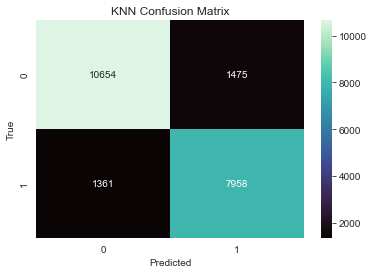

In [34]:
sns.heatmap(confusion_mat, annot=True, fmt = 'd', cmap = 'mako')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix')
plt.show()

In [35]:
TP = 11439 
FP = 2042
FN = 1942
TN = 15218

accuracy = (TP + TN)/ (TP + TN + FP + FN)
sensitivity = TP / (TP+FN)
specificity = TN / (TN+FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall)/ (precision + recall)

print('Accuracy', accuracy *100 ,'\n')
print('Sensitivity', sensitivity*100,'\n')
print('Specificity', specificity*100,'\n')
print('Precision', precision*100,'\n')
print('Recall', recall*100,'\n')
print('F1 - Score', f1_score*100,'\n')
print('RMSE', rmse)

Accuracy 86.99781338729153 

Sensitivity 85.4868843883118 

Specificity 88.16917728852839 

Precision 84.85275573028707 

Recall 85.4868843883118 

F1 - Score 85.16863971409427 

RMSE 0.36363000570888854


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))
print("No Informaiton Rate")
print(np.mean(1-math_df["MathResultNum"]))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     12129
           1       0.84      0.85      0.85      9319

    accuracy                           0.87     21448
   macro avg       0.87      0.87      0.87     21448
weighted avg       0.87      0.87      0.87     21448

No Informaiton Rate
0.5632975425084038


## ROC Curve

In [37]:
from sklearn.metrics import roc_curve, auc
y_scores = cross_val_predict(knn, X, y, cv= 10, method = 'predict_proba')[:,1]


# false/true postive & threshold
fpr, tpr, thresholds = roc_curve(y, y_scores)

#roc calc
roc_auc = auc(fpr, tpr)


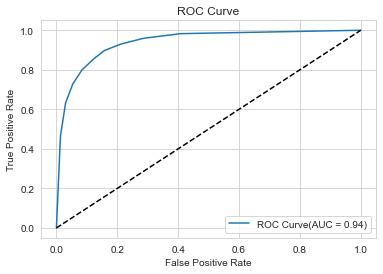

In [38]:
plt.plot(fpr, tpr, label = 'ROC Curve(AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc= 'lower right')


plt.show()

The ROC Curve is represented by the line connecting the points defined by the False Positive Rate (FPR) on the x-axis and the True Positive Rate (TPR) on the y-axis. Each point on the curve corresponds to a different classification threshold. The curve visually illustrates the trade-off between the true positive rate and the false positive rate at different thresholds.

The AUC (Area under the curve) ranges from 0 to 1, where a higher value signifies better discriminative power and overall performance of the model. In this case our AUC is .94. 


### Analyzing Results

- **Accuracy:** 87

- **Precision:** 85

- **Recall:** 85

- **F1 Score:** 85.1

- **AUC-ROC:** 94

### Advantages to Using KNN

- **Simplicity:** KNN is a simple and intuitive algorithm that doesn't require complex assumptions or extensive parameter tuning. It is easy to understand and implement, making it accessible for users with limited machine learning experience. <br><br>
- **Flexibility:** KNN can handle both binary and continuous attributes, making it suitable for datasets with mixed data types. It can effectively incorporate different types of features into the classification process without requiring explicit feature engineering or transformation.
<br><br>
- **Non-linearity:** KNN is a non-parametric algorithm, meaning it doesn't make assumptions about the underlying data distribution. It can capture complex relationships and decision boundaries between features and the target variable, allowing for flexibility in modeling non-linear patterns.
<br><br>
- **Robustness to Outliers:** KNN is robust to outliers because it doesn't make strong assumptions about the data distribution. Outliers may have limited impact on the classification decision, as the majority vote is based on the nearest neighbors. This can be advantageous when dealing with datasets that contain noisy or inconsistent data.
<br><br>
- **Interpretability:** KNN provides interpretability as it can easily explain its predictions. The classification decision is based on the nearest neighbors, which can be visualized and understood by examining the neighboring instances and their corresponding class labels. This can be useful in scenarios where interpretability and explainability are important.
<br><br>
- **No Training Phase:** KNN is a lazy learning algorithm, meaning it does not have an explicit training phase. The model stores the entire training dataset and makes predictions at runtime based on the nearest neighbors. This allows for efficient adaptation to new data or incremental learning scenarios.

# Conclusion - KNN

In this section we performed classification of our data with the KNN model. KNN is a non-parametric algorithm that does not make any assumptions about the underlying data distribution, which can be beneficial when dealing with complex or unknown relationships. Additionally, KNN is a simple yet powerful algorithm that is easy to understand and implement. It does not require training time since it uses the entire training dataset for predictions. KNN is also effective in handling imbalanced datasets, as it considers the nearest neighbors regardless of class distribution.

To gain a better understanding of the data and evaluate the performance of the KNN Classification model for predicting pass or fail on the math test, we utilized two key evaluation techniques: the confusion matrix and the ROC curve.
By utilizing the confusion matrix and ROC curve, we were able to gain valuable insights into the model's predictive capabilities. The confusion matrix allowed us to analyze the accuracy, precision, recall, and F1 score, providing a comprehensive understanding of the model's performance. Meanwhile, the ROC curve and AUC-ROC provided a visual and quantitative assessment of the model's ability to distinguish between pass and fail instances.

These evaluation techniques played a crucial role in assessing the model's effectiveness, identifying areas for improvement, and gaining a deeper understanding of the data and results. By leveraging the insights provided by the confusion matrix and ROC curve, we were able to make informed decisions and adjustments to optimize the KNN Classification model for predicting pass or fail on the math test.

The Results for KNN are as follow:


Accuracy: 87<br>
Precision: 85<br>
Recall: 85<br>
F1 Score: 85.1<br>
AUC-ROC: 94<br>
RMSE: .363<br>

<hr>

# Random Forest and Decision Tree - Danny

### Decision Tree

### Import Necessary Packages

In [39]:
import numpy as np
import pandas as pd

from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
sns.set_style('whitegrid')

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import sklearn.tree as tree

### Train a Decision Tree Model

In [40]:
X = scale_math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = scale_math_df['MathResultNum']

DT_model = DecisionTreeClassifier(random_state=1,max_depth = 5).fit(X,y)

### Plot Decision Tree

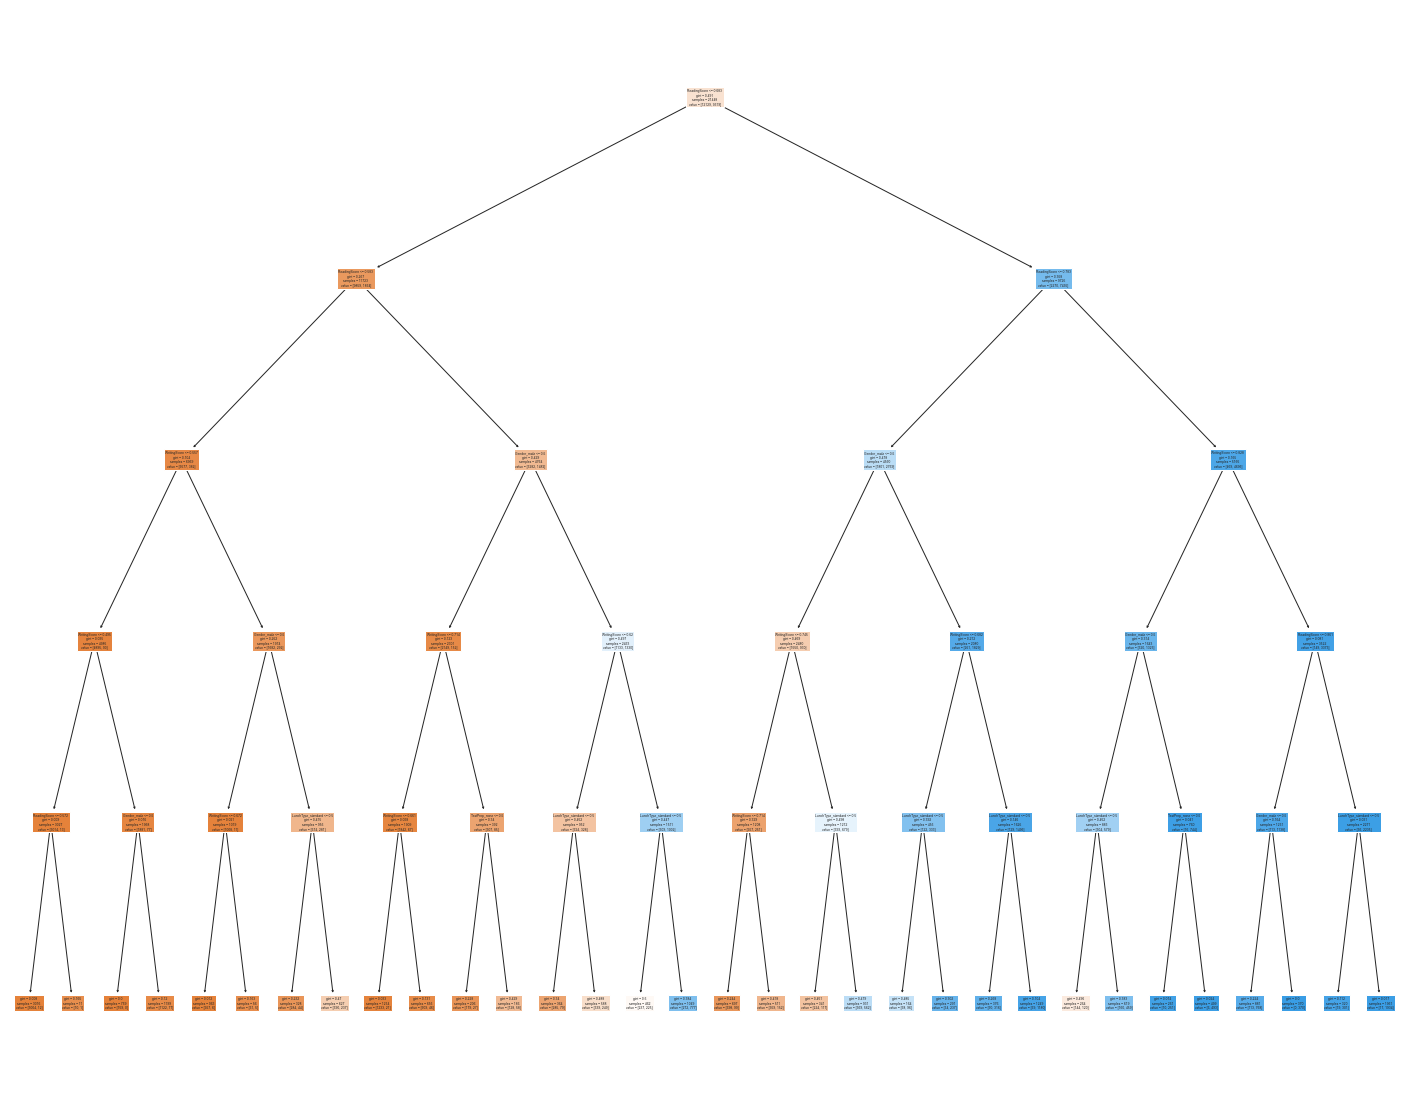

In [41]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DT_model, feature_names= np.array(['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']), filled=True)

### Grid Search

In [42]:
from sklearn.model_selection import GridSearchCV
# Grid Search
#reformat for DT

cv = KFold(n_splits=10, shuffle = True, random_state=1)

a = GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1,2,3,4,5,6,7,8,9]}, cv = cv)
a.fit(X,y)
print('Best max_depth:', a.best_estimator_.get_params()['max_depth'])


Best max_depth: 7


### Internal 10 Cross Validation with Max-Depth = 7

In [43]:
DT_model = DecisionTreeClassifier(random_state = 1, max_depth = 7).fit(X,y)
predsProbs = DT_model.predict(X)
preds = list(map(round,predsProbs))
actual = y


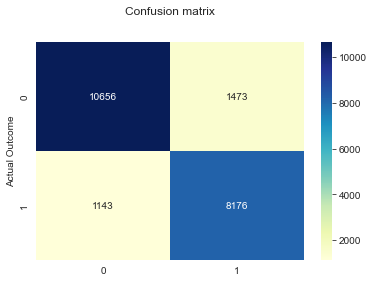

In [44]:
cnf_matrix = metrics.confusion_matrix(actual, preds)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Outcome')
plt.show()

In [45]:
scoresAcc = cross_val_score(DT_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scoresRec = cross_val_score(DT_model, X, y, scoring='recall', cv=cv, n_jobs=-1)
scoresPrec = cross_val_score(DT_model, X, y, scoring='precision', cv=cv, n_jobs=-1)
scoresF1 = cross_val_score(DT_model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scoresAcc), np.std(scoresAcc)))
print('Recall: %.3f (%.3f)' % (np.mean(scoresRec), np.std(scoresRec)))
print('Precision: %.3f (%.3f)' % (np.mean(scoresPrec), np.std(scoresPrec)))
print('F1: %.3f (%.3f)' % (np.mean(scoresF1), np.std(scoresF1)))


Accuracy: 0.873 (0.008)
Recall: 0.867 (0.014)
Precision: 0.845 (0.015)
F1: 0.856 (0.011)


In [46]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(DT_model, X, y, cv=10)

MSE = mean_squared_error(y,y_pred)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)


RMSE: 0.35761810974940644


### Feature Importance

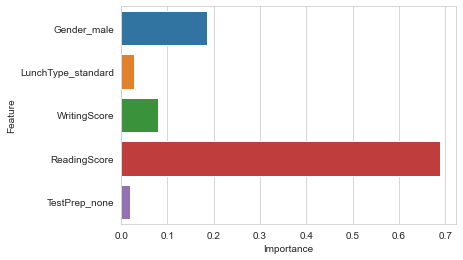

In [47]:
feature_importances = DT_model.feature_importances_

FI = pd.DataFrame({"Feature": ['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none'], "Importance": np.array(feature_importances)})

sns.barplot(y = "Feature", x = "Importance", data = FI)
plt.show()

**Feature Importance allows us to determine which feature is the singificant comparatively, and we see that reading score is a good feature in determining math test pass.**

# Random Forest - Daniel

### Grid Search

In [48]:
#Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Grid Search
#reformat for DT

X = math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = math_df['MathResultNum']


cv = KFold(n_splits=5, shuffle = True, random_state=1)

a = GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50,100,150,200],
                         'max_depth': [5,10],
                 'criterion' :['gini', 'entropy']}
 )
a.fit(X,y)
print('Best max_depth:', a.best_estimator_.get_params()['max_depth'])
print('Best number of trees:', a.best_estimator_.get_params()['n_estimators'])
print('Best Criterion:', a.best_estimator_.get_params()['criterion'])

Best max_depth: 5
Best number of trees: 50
Best Criterion: entropy


### Fit the Forest and get Prediction

In [49]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

# Make a decision tree and train
RF = RandomForestClassifier(random_state=1, max_depth = 5, n_estimators = 100, criterion= 'entropy')
RF_model = RF.fit(X, y)

predsProbs = RF.predict(X)
preds = list(map(round,predsProbs))
actual = y

### Confusion Matrix

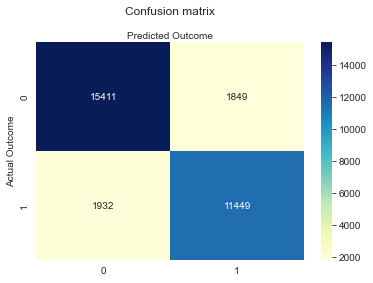

In [50]:
cnf_matrix = metrics.confusion_matrix(actual, preds)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')
plt.show()

In [51]:
from sklearn.metrics import classification_report
print(classification_report(actual, preds))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     17260
           1       0.86      0.86      0.86     13381

    accuracy                           0.88     30641
   macro avg       0.87      0.87      0.87     30641
weighted avg       0.88      0.88      0.88     30641



### Internal 10-Fold CV
Grid Search provided the best parameters as Max Depth = 10 and N_estimators = 100

In [52]:
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, random_state=1, shuffle=True)
cv = KFold(n_splits=5, shuffle = True, random_state=1)
# create model
model = RandomForestClassifier(random_state = 1, max_depth = 5, n_estimators = 200)
# evaluate model

scoresAcc = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scoresRec = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
scoresPrec = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
scoresF1 = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scoresAcc), np.std(scoresAcc)))
print('Recall: %.3f (%.3f)' % (np.mean(scoresRec), np.std(scoresRec)))
print('Precision: %.3f (%.3f)' % (np.mean(scoresPrec), np.std(scoresPrec)))
print('F1: %.3f (%.3f)' % (np.mean(scoresF1), np.std(scoresF1)))

Accuracy: 0.875 (0.005)
Recall: 0.851 (0.006)
Precision: 0.861 (0.010)
F1: 0.856 (0.006)


In [53]:
MSE = mean_squared_error(actual,preds)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)


RMSE: 0.3512787439919315


**Comparing CV Results:**
Comparing CV results with our sinigle hold out, we see that both are very similar in terms of Accuracy, Recall, Precision, and F1. Good overall metrics hovering around 85%, which indicates a possible useful model.

### Feature Importance

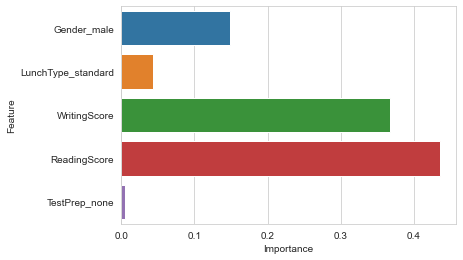

In [54]:
fi = RF.feature_importances_

FI = pd.DataFrame({"Feature": ['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none'], "Importance": np.array(fi)})
FI
sns.barplot(y = "Feature", x = "Importance", data = FI)
plt.show()

**Feature Importance Analysis:**
In our feature importance, we see that the Reading and Writing scores are highly valued features that can possibly be a useful explanatory variable for our response of students will pass the math test. It makes sense if you are a good reader and writer that you have a good chance to also pass a test. At the end of a day, you are taking a test, and if you are good at taking a test, math would probably have similar results.

### Comparing Results (Stratified 10-Fold Cross Validation)

| Metric    | Decision Tree | RandomForest  |
|---------|-----|----------|
| **Accuracy**    | 0.874  | 0.875 |
|  **Precision**   | 0.861  | 0.859   |
| **Recall** | 0.853 | 0.855   |
| **F1 Score**  | 0.857  | 0.855    |
| **RMSE**  | 0.354  | 0.352    |


### Advantages to Using Random Forest

- **Feature Importance:** Random Forest models provide a feature importance measure, which help us identify the influetial features in making predictions. This can help understand a relationship between the feature and target variable. <br><br>
- **Usefulness in High-Dimensional Data:** Random Forest can handle high-dimensional data effectively, as it automatically select informative features and split and ignore anything irrelevant. There are strong metrics usch as entrophy or gini to help reduce any noise.
<br><br>
- **Robustness to Noise and Outliers:** Random Forest models is the best out of our models in terms of being more robust to noisy data. The Random Forest aggregate predictions from multiple trees, reducing the impact of outliers and noisy istances.
<br><br>


# Conclusion

Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. This ensemble approach improves the model's robustness and reduces overfitting, as each tree is trained on a different subset of the data and features. Secondly, Random Forest can handle both numerical and categorical features effectively, making it suitable for diverse types of input data. It can automatically handle feature interactions and non-linear relationships, which is advantageous when dealing with complex datasets.

Similar to our previous models we utilized ROC (Receiver Operating Characteristic) curve to assess the model's predictive ability. The ROC curve displayed the relationship between the true positive rate and the false positive rate at different classification thresholds.

The combination of the confusion matrix and ROC curve allowed us to gain a deeper understanding of the Random Forest model's strengths and weaknesses. The confusion matrix provided a comprehensive overview of the model's accuracy metrics, such as precision, recall, and F1 score. On the other hand, the ROC curve and AUC-ROC provided a visual representation and a numerical measure of the model's ability to correctly classify pass and fail instances.

Finally our results for the Random Forest are as follow:

Accuracy: .875<br>
Precision: .859<br>
Recall: .855<br>
F1 Score: .855<br>
RMSE: .352<br>

<hr>

#  Exceptional Work | Process Recreation with More Features & Grid Searches

In [55]:
df = pd.read_csv('cleandf.csv')

In [56]:
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore,MathResult,ReadingResult,WritingResult
0,female,group C,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74,Pass,Pass,Pass
1,female,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,69,90,88,Fail,Pass,Pass
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91,Pass,Pass,Pass
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,school_bus,5 - 10,45,56,42,Fail,Fail,Fail
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75,Pass,Pass,Pass


In [57]:
df_dummy = pd.get_dummies(df, columns=['Gender', 'LunchType', 'TestPrep', 'IsFirstChild','TransportMeans', 
                                      'EthnicGroup','ParentEduc','ParentMaritalStatus'],
                          drop_first=True)
df_dummy["WklyStudyHours"] = [1 if x == '> 10' else 0 for x in df_dummy["WklyStudyHours"]]

df_dummy["PracticeSport"] = [0 if x == 'never' else 1 for x in df_dummy["PracticeSport"]]

math_df = df_dummy.drop(["ReadingResult", "WritingResult", "MathScore"], axis = 1)

math_df['HasSiblings'] = math_df['NrSiblings'].apply(lambda x: 1 if x > 0 else 0)

math_df.drop('NrSiblings', axis=1, inplace=True)

In [58]:
math_df['MathResultNum'] = np.where(math_df['MathResult'] == "Pass", 1, 0)

In [59]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_math_df = math_df
scale_math_df[['ReadingScore','WritingScore']] = scaler.fit_transform(math_df[['ReadingScore','WritingScore']])

In [60]:
X = scale_math_df.drop(['MathResultNum','MathResult'], axis = 1)
#X = scale_math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = scale_math_df['MathResultNum']

<hr>

# KNN - Updated

In [61]:
knn = KNeighborsClassifier()

In [62]:
param_grid = {'n_neighbors':[2,3,5,7,9,11,13,15,19]}

grid_search = GridSearchCV(knn, param_grid, cv = 5)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 5, 7, 9, 11, 13, 15, 19]})

In [63]:
grid_search_results = grid_search.cv_results_
print('Grid Search Results')
for mean_score, params in zip(grid_search_results['mean_test_score'], grid_search_results['params']):
    print(f'Parameters: {params} | Mean Accuracy: {mean_score}')

Grid Search Results
Parameters: {'n_neighbors': 2} | Mean Accuracy: 0.7622142059302031
Parameters: {'n_neighbors': 3} | Mean Accuracy: 0.7871155651746801
Parameters: {'n_neighbors': 5} | Mean Accuracy: 0.7937733848454911
Parameters: {'n_neighbors': 7} | Mean Accuracy: 0.796645181257447
Parameters: {'n_neighbors': 9} | Mean Accuracy: 0.8009857259520825
Parameters: {'n_neighbors': 11} | Mean Accuracy: 0.8053915607732277
Parameters: {'n_neighbors': 13} | Mean Accuracy: 0.8070234092341038
Parameters: {'n_neighbors': 15} | Mean Accuracy: 0.8075455758204692
Parameters: {'n_neighbors': 19} | Mean Accuracy: 0.8109723675953935


In [64]:
best_knn = grid_search.best_estimator_
print(best_knn)

KNeighborsClassifier(n_neighbors=19)


In [65]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors = 9)

cross_val_scores = cross_val_score(knn, X, y, cv=10)

In [66]:
print('Cross-Validation Score:',cross_val_scores)

Cross-Validation Score: [0.78858075 0.8035248  0.80124021 0.81201044 0.79079634 0.80483029
 0.8035248  0.80678851 0.82180157 0.79569191]


In [67]:
avg_accuracy = cross_val_scores.mean()

print('Average Accuracy', avg_accuracy)

Average Accuracy 0.8028789627692425


In [68]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(knn, X, y, cv=10)

In [69]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)
print('RMSE', rmse)

RMSE 0.44398367522620386


In [70]:
confusion_mat = confusion_matrix(y, y_pred)
print('Confusion Matrix', confusion_mat)

Confusion Matrix [[14477  2783]
 [ 3257 10124]]


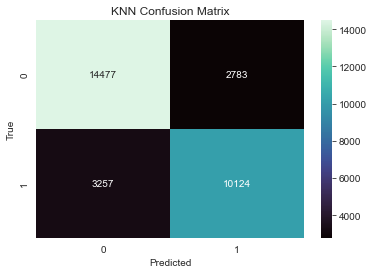

In [71]:
sns.heatmap(confusion_mat, annot=True, fmt = 'd', cmap = 'mako')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix')
plt.show()

In [72]:
TP = 11439 
FP = 2042
FN = 1942
TN = 15218

accuracy = (TP + TN)/ (TP + TN + FP + FN)
sensitivity = TP / (TP+FN)
specificity = TN / (TN+FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall)/ (precision + recall)

print('Accuracy', accuracy *100 ,'\n')
print('Sensitivity', sensitivity*100,'\n')
print('Specificity', specificity*100,'\n')
print('Precision', precision*100,'\n')
print('Recall', recall*100,'\n')
print('F1 - Score', f1_score*100,'\n')
print('RMSE', rmse)

Accuracy 86.99781338729153 

Sensitivity 85.4868843883118 

Specificity 88.16917728852839 

Precision 84.85275573028707 

Recall 85.4868843883118 

F1 - Score 85.16863971409427 

RMSE 0.44398367522620386


In [113]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))
print("No Informaiton Rate")
print(np.mean(1-math_df["MathResultNum"]))

ValueError: Found input variables with inconsistent numbers of samples: [21448, 30641]

In [74]:
from sklearn.metrics import roc_curve, auc
y_scores = cross_val_predict(knn, X, y, cv= 10, method = 'predict_proba')[:,1]


# false/true postive & threshold
fpr, tpr, thresholds = roc_curve(y, y_scores)

#roc calc
roc_auc = auc(fpr, tpr)


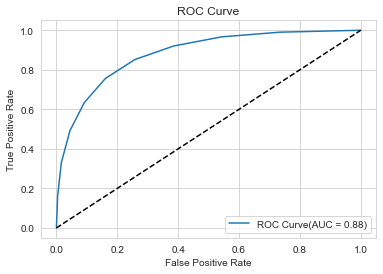

In [75]:
plt.plot(fpr, tpr, label = 'ROC Curve(AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc= 'lower right')


plt.show()

## Model Evaluation on Test Set: Top Features

In [109]:
#Test Set
X = Train_entire.drop(["EthnicGroup", "ParentEduc", "ParentMaritalStatus", "MathResult", "HasSiblings","MathResultNum"], axis = 1)
y = Train_entire.MathResultNum
XT = Test_entire.drop(["EthnicGroup", "ParentEduc", "ParentMaritalStatus", "MathResult", "HasSiblings","MathResultNum"], axis = 1)
actual = Test_entire.MathResultNum 



In [112]:
import warnings

# Suppress warning messages
warnings.filterwarnings("ignore")

#Logistic Model
log_model = LogisticRegression(random_state=1).fit(X,y)
threshold = 0.3886995893248815

log_clf_probs = log_model.predict_proba(XT)[:,1]
log_preds = np.where(log_clf_probs >= threshold, 1, 0)

print("Logistic Classification Report:")
print(classification_report(actual, log_preds))

# KNN Model
knn = KNeighborsClassifier(n_neighbors = 9)
knn_pred = knn.fit(X,y).predict(XT)
print("KNN Classification Report:")
print(classification_report(actual, knn_pred))

#RandomForest
RF_model = RandomForestClassifier(random_state = 1, max_depth = 5, n_estimators = 200).fit(X,y)
predsProbs = RF_model.predict(XT)
RF_preds = list(map(round,predsProbs))
print("RandomForest Classification Report:")
print(classification_report(actual, RF_preds))






Logistic Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      5131
           1       0.84      0.90      0.87      4062

    accuracy                           0.88      9193
   macro avg       0.88      0.88      0.88      9193
weighted avg       0.89      0.88      0.88      9193

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      5131
           1       0.84      0.84      0.84      4062

    accuracy                           0.86      9193
   macro avg       0.86      0.86      0.86      9193
weighted avg       0.86      0.86      0.86      9193

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      5131
           1       0.87      0.85      0.86      4062

    accuracy                           0.88      9193
   macro avg       0.87      0.87

<hr>

# Task 2: Full Features

### Dataframe of full features

In [117]:
df_dummy = pd.get_dummies(df, columns=['Gender','EthnicGroup', 'LunchType', 'TestPrep',"ParentMaritalStatus", 'IsFirstChild','TransportMeans',"ParentEduc"],
                          drop_first=True)
df_dummy["WklyStudyHours"] = [1 if x == '> 10' else 0 for x in df_dummy["WklyStudyHours"]]

df_dummy["PracticeSport"] = [0 if x == 'never' else 1 for x in df_dummy["PracticeSport"]]

math_df = df_dummy.drop(["ReadingResult", "WritingResult", "MathScore"], axis = 1)

math_df['HasSiblings'] = math_df['NrSiblings'].apply(lambda x: 1 if x > 0 else 0)



### Nomralize Features

In [154]:
scaler = MinMaxScaler()
scale_math_df = math_df
scale_math_df[['ReadingScore','WritingScore',"NrSiblings"]] = scaler.fit_transform(scale_math_df[['ReadingScore','WritingScore',"NrSiblings"]])


In [155]:
scale_math_df['MathResultNum'] = np.where(scale_math_df['MathResult'] == "Pass", 1, 0)
scale_math_df = scale_math_df.drop(["MathResult"], axis = 1)


### Train and Test Split

In [161]:
from sklearn.model_selection import train_test_split

Train, Test= train_test_split(scale_math_df, train_size = .7, test_size= .3, random_state=5)

In [167]:
X_train = Train.drop("MathResultNum",axis=1)
y_train = Train.MathResultNum
XT = Test.drop("MathResultNum",axis=1)
actual = Test.MathResultNum

### Classification Reports (External Cross Validation)

In [168]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

log_model = LogisticRegression(random_state=1).fit(X_train,y_train)
log_preds = log_model.predict(XT)


KNN = KNeighborsClassifier(n_neighbors = 9)
knn_preds = KNN.fit(X_train,y_train).predict(XT)

RF = make_pipeline(StandardScaler(),RandomForestClassifier(random_state = 1, max_depth = 5, n_estimators = 200))
RF_preds = RF.fit(X_train,y_train).predict(XT)

print("Logistic Classification Report:")
print(classification_report(actual, log_preds))
print("KNN Classification Report:")
print(classification_report(actual, knn_preds))
print("RandomForest Classification Report:")
print(classification_report(actual, RF_preds))

Logistic Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      5131
           1       0.88      0.86      0.87      4062

    accuracy                           0.89      9193
   macro avg       0.88      0.88      0.88      9193
weighted avg       0.89      0.89      0.89      9193

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      5131
           1       0.76      0.72      0.74      4062

    accuracy                           0.78      9193
   macro avg       0.78      0.77      0.77      9193
weighted avg       0.78      0.78      0.78      9193

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      5131
           1       0.86      0.81      0.83      4062

    accuracy                           0.86      9193
   macro avg       0.86      0.85

# Full Conclusion

<hr>

# Deployment

**How useful is your model for interested parties?**
- The intended beneficiaries of our modeling process are educational institutions, school districts, and students requiring special attention, either for their exceptional talent or for additional support. We posit that our model can effectively identify knowledge gaps and determine the need for supplementary assistance to succeed in mathematics tests. Given that mathematics tests serve as key indicators of aptitude for pursuing careers in engineering or data science, our model holds potential value for companies seeking to target students for enhanced preparation or identify the growth potential within school districts. This type of modeling holds significant importance for all students, as it enables them to ascertain their current academic standing—an essential aspect in today's rapidly evolving world. By assisting students in achieving their goal of passing mathematics tests or attaining satisfactory scores, our model offers substantial utility.

**How would you measure the models's value if it was used by these parties?**
- The efficacy of our model lies in its ability to accurately predict whether a student will successfully pass their mathematics test. However, building trust in our model may present some challenges, as stakeholders might have concerns regarding confidence levels. Therefore, it is crucial for us to ensure the provision of reliable confidence intervals. It is essential to approach the identification of students in need of additional support with sensitivity, as individuals, including parents, may be averse to being labeled as failures or requiring extra assistance. Consequently, we must prioritize the accuracy of our model in identifying students who require support to succeed.

- Drawing from my own expertise in the field, it is worth noting that schools are assessed based on their performance in tests. While test performance holds significance for all students, it has become particularly critical in the post-COVID era, where the successful completion of state exams has become a prerequisite for advancing to the next grade. Our model can play a pivotal role in early identification of students who may require additional tutoring, particularly after the first and third mid-semester exams. By promptly recognizing such students and assigning them appropriate tutoring resources, we can significantly enhance their chances of passing the state exams.

**How would you deploy your model for interested parties?**
- In implementing this model, my initial focus would be on utilizing it to monitor the progress of at-risk students in preparation for the state exams. To ensure transparency and gain necessary approvals, I would seek permission and present the model's methodology to district personnel or individuals knowledgeable in its workings. Subsequently, I would collaborate with the data department to acquire relevant data, enabling us to further enhance and refine the model's training. Once ready, I would deploy the model through the district's data portal, providing teachers with the ability to identify students who may be at risk of underperforming.

- By targeting at-risk students and closely monitoring their progress using this model, we can effectively intervene and provide timely support to improve their chances of success in the state exams. The step-by-step process outlined above ensures compliance, data integrity, and the seamless integration of the model into the existing infrastructure of the educational system.


**What other data should be collected?** 
- In addition to academic performance data, collecting additional relevant data can provide valuable insights for a comprehensive understanding of the students. Some suggested data that could be considered are:

- Physical characteristics: Gathering information such as age, gender, ethnicity, and health status can help identify potential patterns or correlations between these factors and academic performance.

- Emotional profiles: Assessing students' emotional well-being, self-esteem, motivation, and attitudes towards learning can provide insights into their overall socio-emotional development and how it may impact their academic performance.

- Survey data on home life and cultural background: Understanding students' home environments, including parental education levels, socioeconomic status, and cultural factors, can contribute to a more holistic analysis. This data can shed light on potential external influences that may affect a student's learning experience.

- Collecting this additional data can enrich the analysis and help identify potential factors beyond academic knowledge that may contribute to a student's performance. However, it is important to prioritize privacy and obtain appropriate consent when collecting sensitive information, ensuring compliance with ethical guidelines and regulations.

**How often would the model need to be updated?**
- To ensure the model remains effective and relevant, regular updates are essential. Given the proposed timeline and the availability of new data, it is recommended to update the model on an annual basis. By updating the model annually, it allows for the incorporation of new training data from diverse students, which helps to improve the model's accuracy and adaptability over time.

- Updating the model yearly also accounts for potential changes in educational practices, curriculum, and testing standards that may impact the predictive power of the model. It enables the inclusion of the most up-to-date information and ensures the model remains aligned with current educational requirements.

- However, the specific frequency of updates may vary depending on factors such as the availability of new data, changes in student demographics, and advancements in modeling techniques. Regular monitoring and evaluation should be conducted to assess the need for more frequent updates or adjustments to the update schedule to maintain the model's efficacy.